In [1]:
import pandas as pd
import numpy as np
import requests
from PIL import Image
from io import BytesIO
import os
from transformers import CLIPProcessor, CLIPModel
import torch
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
df_offline = pd.read_csv("./datasets/exhibition_feature_offline.csv")

In [3]:
df_offline

,systemNumber,_images__primary_thumbnail,briefDescription,local_image_path,text_features,image_features
0,O22904,https://framemark.vam.ac.uk/collections/2006AW...,"Yixing ware. Teapot, brown stoneware in the fo...",downloaded_images\O22904.jpg,[-5.36122499e-03 4.14749831e-02 -1.02468720e-...,[-4.50202860e-02 3.41264419e-02 -1.09552601e-...
1,O187757,https://framemark.vam.ac.uk/collections/2010EB...,"Yixing ware. Dish, in the form of a peach with...",downloaded_images\O187757.jpg,[-5.90480603e-02 4.59225550e-02 2.14791596e-...,[-4.90153357e-02 4.63838950e-02 -1.33689586e-...
2,O185533,https://framemark.vam.ac.uk/collections/2010EB...,"Yixing ware. Vase, brown stoneware with mottle...",downloaded_images\O185533.jpg,[ 1.61672626e-02 5.09738922e-02 -1.10796411e-...,[-1.77562907e-02 3.89144011e-02 -2.48709787e-...
3,O162180,https://framemark.vam.ac.uk/collections/2014GY...,Salt-glazed stoneware tankard with pewter moun...,downloaded_images\O162180.jpg,[-1.06526930e-02 8.34742337e-02 -7.06270849e-...,[-3.01263910e-02 5.84345460e-02 -9.31857806e-...
4,O151257,https://framemark.vam.ac.uk/collections/2008BV...,NaN,downloaded_images\O151257.jpg,NaN,[ 9.80557501e-03 3.51845659e-02 -5.12989529e-...
...,...,...,...,...,...,...
1945,O157075,https://framemark.vam.ac.uk/collections/2009CP...,"Silver, parcel-gilt, London, (no hallmarks), c...",downloaded_images\O157075.jpg,[-2.09466629e-02 -5.99700119e-03 -1.30470376e-...,[-2.56949123e-02 3.50271538e-02 -1.14793461e-...
1946,O148514,https://framemark.vam.ac.uk/collections/2008BT...,Red earthenware tyg with relief decoration in ...,downloaded_images\O148514.jpg,[-4.32110094e-02 6.54722080e-02 -9.36303940e-...,[-1.20778959e-02 5.06230667e-02 2.03046091e-...
1947,O8072,https://framemark.vam.ac.uk/collections/2006AJ...,"Delftware mug, painted in blue with birds, flo...",downloaded_images\O8072.jpg,[ 2.64659263e-02 1.71568501e-03 2.48342901e-...,[-3.16911116e-02 3.43128294e-02 1.76959112e-...
1948,O70493,https://framemark.vam.ac.uk/collections/2008BT...,"Tea bowl, Raku ware, Kyoto, attributed to Raku...",downloaded_images\O70493.jpg,[-5.33806439e-03 6.22669011e-02 4.04261909e-...,[ 3.36328335e-03 1.83518305e-02 -2.81873271e-...


In [4]:
# 使用训练好的CLIP模型
model = CLIPModel.from_pretrained("D:\_HuggingFace_\clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("D:\_HuggingFace_\clip-vit-base-patch32")

In [5]:
text_embed_dim = model.text_projection
image_embed_dim = model.visual_projection

print(f"Text Embedding Dimension: {text_embed_dim}")
print(f"Image Embedding Dimension: {image_embed_dim}")

Text Embedding Dimension: Linear(in_features=512, out_features=512, bias=False)
Image Embedding Dimension: Linear(in_features=768, out_features=512, bias=False)


In [6]:
# df_offline = df_offline.dropna()

In [7]:
def parse_text_features(x):
    if pd.isna(x): 
        return np.zeros(512) 
    else:
        try:
            return np.fromstring(x.strip('[]'), sep=' ')  
        except Exception as e:
            print(f"Error parsing '{x}': {e}")
            return np.zeros(512) 

In [8]:
df_offline['text_features'] = df_offline['text_features'].apply(lambda x: parse_text_features(x))
df_offline['image_features'] = df_offline['image_features'].apply(lambda x: parse_text_features(x))

In [9]:
# df_offline['text_features'] = df_offline['text_features'].apply(lambda x: np.fromstring(x.strip('[]'), sep=' '))
# df_offline['image_features'] = df_offline['image_features'].apply(lambda x: np.fromstring(x.strip('[]'), sep=' '))

In [10]:
text_features_tensor = torch.tensor(df_offline['text_features'].tolist(), dtype=torch.float32)
image_features_tensor = torch.tensor(df_offline['image_features'].tolist(), dtype=torch.float32)

D:\Anaconda\envs\python37\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:233.)
  """Entry point for launching an IPython kernel.


In [11]:
text_features_tensor.shape == image_features_tensor.shape

True

In [12]:
combined_features_tensor = text_features_tensor + image_features_tensor
combined_features_array = combined_features_tensor.numpy()

df_offline['combined_features'] = list(combined_features_array)

In [13]:
df_offline

,systemNumber,_images__primary_thumbnail,briefDescription,local_image_path,text_features,image_features,combined_features
0,O22904,https://framemark.vam.ac.uk/collections/2006AW...,"Yixing ware. Teapot, brown stoneware in the fo...",downloaded_images\O22904.jpg,"[-0.00536122499, 0.0414749831, -0.010246872, -...","[-0.045020286, 0.0341264419, -0.0109552601, -0...","[-0.05038151, 0.07560143, -0.021202132, -0.063..."
1,O187757,https://framemark.vam.ac.uk/collections/2010EB...,"Yixing ware. Dish, in the form of a peach with...",downloaded_images\O187757.jpg,"[-0.0590480603, 0.045922555, 0.0214791596, -0....","[-0.0490153357, 0.046383895, -0.0133689586, -0...","[-0.1080634, 0.09230645, 0.008110201, -0.05763..."
2,O185533,https://framemark.vam.ac.uk/collections/2010EB...,"Yixing ware. Vase, brown stoneware with mottle...",downloaded_images\O185533.jpg,"[0.0161672626, 0.0509738922, -0.0110796411, -0...","[-0.0177562907, 0.0389144011, -0.0248709787, -...","[-0.0015890282, 0.08988829, -0.03595062, -0.05..."
3,O162180,https://framemark.vam.ac.uk/collections/2014GY...,Salt-glazed stoneware tankard with pewter moun...,downloaded_images\O162180.jpg,"[-0.010652693, 0.0834742337, -0.00706270849, -...","[-0.030126391, 0.058434546, -0.00931857806, -0...","[-0.040779084, 0.14190878, -0.016381286, -0.02..."
4,O151257,https://framemark.vam.ac.uk/collections/2008BV...,NaN,downloaded_images\O151257.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00980557501, 0.0351845659, -0.000512989529,...","[0.009805575, 0.035184566, -0.0005129895, -0.0..."
...,...,...,...,...,...,...,...
1945,O157075,https://framemark.vam.ac.uk/collections/2009CP...,"Silver, parcel-gilt, London, (no hallmarks), c...",downloaded_images\O157075.jpg,"[-0.0209466629, -0.00599700119, -0.0130470376,...","[-0.0256949123, 0.0350271538, -0.0114793461, 0...","[-0.046641573, 0.029030152, -0.024526384, 0.05..."
1946,O148514,https://framemark.vam.ac.uk/collections/2008BT...,Red earthenware tyg with relief decoration in ...,downloaded_images\O148514.jpg,"[-0.0432110094, 0.065472208, -0.0093630394, 0....","[-0.0120778959, 0.0506230667, 0.0203046091, 0....","[-0.055288903, 0.116095275, 0.01094157, 0.0365..."
1947,O8072,https://framemark.vam.ac.uk/collections/2006AJ...,"Delftware mug, painted in blue with birds, flo...",downloaded_images\O8072.jpg,"[0.0264659263, 0.00171568501, 0.0248342901, 0....","[-0.0316911116, 0.0343128294, 0.0176959112, 0....","[-0.0052251853, 0.036028516, 0.0425302, 0.0350..."
1948,O70493,https://framemark.vam.ac.uk/collections/2008BT...,"Tea bowl, Raku ware, Kyoto, attributed to Raku...",downloaded_images\O70493.jpg,"[-0.00533806439, 0.0622669011, 0.0404261909, -...","[0.00336328335, 0.0183518305, -0.0281873271, -...","[-0.001974781, 0.08061873, 0.012238864, -0.019..."


In [14]:
# 导出数据
output_file_path = './datasets/exhibition_feature_offline_combined.csv'
df_offline.to_csv(output_file_path, index=False)

In [15]:
# 计算余弦相似度
def cosine_similarity(query, items):
    # query: [1, 512], items: [num_items, 512]
    query = F.normalize(query, p=2, dim=-1)
    items = F.normalize(items, p=2, dim=-1)
    return torch.mm(query, items.t()) 

In [16]:
# 检索函数
def search(user_query_text=None, user_query_image=None, k=5):
    
    if user_query_text is not None and user_query_image is not None:
        combined_query = user_query_text + user_query_image
        similarity_scores = cosine_similarity(combined_query.unsqueeze(0), combined_features_tensor)
        
    elif user_query_text is not None:
        similarity_scores = cosine_similarity(user_query_text.unsqueeze(0), text_features_tensor)
        
    elif user_query_image is not None:
        similarity_scores = cosine_similarity(user_query_image.unsqueeze(0), image_features_tensor)
        
    else:
        raise ValueError("At least one of user_query_text or user_query_image must be provided.")
        
    top_k_indices = torch.topk(similarity_scores, k, dim=1).indices.squeeze(0)

    search_items = top_k_indices.tolist()
    return search_items

In [17]:
# 展示结果
def display_most_similar(most_similar_df):
    for idx, row in most_similar_df.iterrows():
        print(f"\nSystem Number: {row['systemNumber']}")
        print(f"Brief Description: {row.get('briefDescription', 'No brief description available')}")
        image_link = row.get('images__primary_thumbnail', 'No image link available')
        print(f"Image Link: {image_link}")
        gallery_label = row.get('galleryLabels_0_text', 'No gallery label available')
        image_filename = f"{row['systemNumber']}.jpg"
        image_path = os.path.join(".\downloaded_images", image_filename)
        
        if os.path.exists(image_path):
            try:
                img = Image.open(image_path)
                plt.figure(figsize=(6, 6))
                plt.imshow(img)
                plt.axis('off')
                plt.show()
            except Exception as e:
                print(f"Failed to display image {image_path}: {e}")
        else:
            print("No image available for this system number.")
        print("=" * 100)

In [18]:
# should be input
# user_query_text = wenwu_offline['text_features'][0]
# user_query_image = wenwu_offline['image_features'][0]

# user_query_text = torch.tensor(user_query_text, dtype=torch.float32)
# user_query_image = torch.tensor(user_query_image, dtype=torch.float32)

In [19]:
# image & text
# recommended_items = recommend_items(user_query_text=user_query_text, user_query_image=user_query_image)
# selected_rows = wenwu_offline.iloc[recommended_items]

# display_most_similar(selected_rows)

In [20]:
# Simulations

In [21]:
# 读取txt文件
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
    return content

In [22]:
# 处理图像
def preprocess_image(image_path, target_size=(100, 100)):
    image = Image.open(image_path).convert("RGB")
    image_resized = image.resize(target_size, Image.ANTIALIAS)
    inputs = processor(images=image_resized, return_tensors="pt")
    with torch.no_grad():
        outputs = model.get_image_features(**inputs)
    image_features = outputs.numpy().squeeze()
    return image_features, image_resized

# 处理文本
def preprocess_text(text_path):
    with open(text_path, 'r', encoding='utf-8') as file:
        text = file.read().strip()
    inputs = processor(text=text, return_tensors="pt", padding=True, truncation=True, max_length=77)
    with torch.no_grad():
        outputs = model.get_text_features(**inputs)
    text_features = outputs.numpy().squeeze()
    return text_features

In [24]:
# 模拟用户输入
image_path = "./user_input/user_photo.png"
text_path = "./user_input/user_text.txt"

user_query_image, _ = preprocess_image(image_path)
user_query_text = preprocess_text(text_path)

user_query_text = torch.tensor(user_query_text, dtype=torch.float32)
user_query_image = torch.tensor(user_query_image, dtype=torch.float32)

D:\Anaconda\envs\python37\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  after removing the cwd from sys.path.


a close-up of a blue and white patterned surface, likely ceramic or porcelain, with a traditional design.


D:\Anaconda\envs\python37\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  after removing the cwd from sys.path.


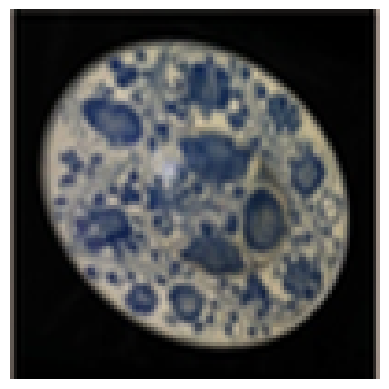

In [25]:
# 用户输入展示
_, image_resized = preprocess_image(image_path)

plt.imshow(image_resized)
plt.axis('off')
print(read_text_file(text_path))

In [26]:
# 检索结果展示
search_items = search(user_query_text=user_query_text, user_query_image=user_query_image)
selected_rows = df_offline.iloc[search_items]

display_most_similar(selected_rows)


System Number: O161093
Brief Description: Earthenware dish with decoration in blue on a white slip and under a clear glaze. Romanian (Tara Barsei region, Transylvania), 18th century.
Image Link: No image link available
No image available for this system number.

System Number: O136593
Brief Description: Sherd of a porcelain bowl, decorated in underglaze cobalt blue, Qing dynasty, China.
Image Link: No image link available
No image available for this system number.

System Number: O437297
Brief Description: Yixing ware. Cup, stoneware with mottled blue and white glaze; China (Yixing), 17th century
Image Link: No image link available
No image available for this system number.

System Number: O151234
Brief Description: Dessert dish of salt-glazed stoneware, press-moulded, made in Staffordshire, ca. 1760.
Image Link: No image link available
No image available for this system number.

System Number: O71194
Brief Description: Mug of salt-glazed stoneware with incised blue decoration, cylind